## Раздел 0: Подготовка

In [2]:
# Импорт необходимых библиотек

!wget https://github.com/andrew-veriga/DL/raw/master/assign.zip
!unzip -u assign.zip
!rm assign.zip

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

from rlglue.rl_glue import RLGlue
import main_agent
import ten_arm_env
import test_env

--2024-09-17 07:41:27--  https://github.com/andrew-veriga/DL/raw/master/assign.zip
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/andrew-veriga/DL/master/assign.zip [following]
--2024-09-17 07:41:27--  https://raw.githubusercontent.com/andrew-veriga/DL/master/assign.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6294 (6.1K) [application/zip]
Saving to: ‘assign.zip’

assign.zip          100%[===================>]   6.15K  --.-KB/s    in 0s      

2024-09-17 07:41:27 (52.9 MB/s) - ‘assign.zip’ saved [6294/6294]

Archive:  assign.zip
  inflating: main_agent.py           
   creating: rlglue/


## Раздел 1: Жадный агент

In [3]:
import numpy as np

def argmax(q_values):
    """
    Принимает список q_values и возвращает индекс элемента
    с наибольшим значением. Разрывает связи случайным образом.

    возвращает: int - индекс самого высокого значения в q_values
    """
    top_value = float("-inf")
    ties = []

    for i in range(len(q_values)):
        if q_values[i] > top_value:
            # Если ценность в q_values больше, чем наивысшая, обновить top_value
            top_value = q_values[i]
            ties = [i]  # Сбросить ties и добавить текущий индекс
        elif q_values[i] == top_value:
            # Если ценность равна top_value, добавить индекс к ties
            ties.append(i)

    # Вернуть случайно выбранный индекс из ties.
    return np.random.choice(ties)

In [4]:
# --------------
# Отладочная ячейка
# --------------

test_array = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
assert argmax(test_array) == 8, "Check your argmax implementation returns the index of the largest value"

# убедитесь, что np.random.choice вызвана корректно
np.random.seed(0)
test_array = [1, 0, 0, 1]

assert argmax(test_array) == 0

# В этом случае мы ожидаем индекс 0 или 3. Поскольку мы используем фиксированное значение seed,
# то результат будет предсказуемым.
assert argmax(test_array) in [0, 3], "The result should be either index 0 or index 3"

print("Всё гуд")

Всё гуд


In [5]:
# -----------
# Тестовая ячейка
# -----------

test_array = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
assert argmax(test_array) == 8, "Check your argmax implementation returns the index of the largest value"

# Установить случайное начальное число, чтобы результаты были детерминированными
np.random.seed(0)
test_array = [1, 0, 0, 1]

counts = [0, 0, 0, 0]
for _ in range(100):
    a = argmax(test_array)
    counts[a] += 1

# убедиться, что argmax не всегда выбирает первое вхождение
assert counts[0] != 100, "Make sure your argmax implementation randomly choooses among the largest values."

# убедиться, что argmax не всегда выбирает последнее вхождение
assert counts[3] != 100, "Make sure your argmax implementation randomly choooses among the largest values."

# убедиться, что генератор случайных чисел вызван только один раз когда бы  `argmax` ни вызывался
expected = [44, 0, 0, 56] # <-- обратите внимание: не однородный из-за случайности
assert counts == expected

In [6]:
import numpy as np

class GreedyAgent(main_agent.Agent):
    def __init__(self, num_actions):
        # Инициализация переменных класса
        self.q_values = np.zeros(num_actions)  # Массив для хранения ценностей действий
        self.arm_count = np.zeros(num_actions)  # Счетчик для каждого действия
        self.last_action = None  # Действие, совершенное на предыдущем шаге

    def agent_step(self, reward, observation):
        """
        Один шаг агента. Входные параметры: награда, наблюдения
        возвращает действие, которое агент выбирает на этом временном шаге.

        Аргументы:
        reward -- float, награда, которую агент получил от окружения после выполнения последнего действия.
        observation -- float, наблюдаемое состояние, в котором находится агент.
        Возвращаемое значение:
        current_action -- int, действие, выбранное агентом на текущем временном шаге.
        """

        ### Переменные класса ###
        # self.q_values : Массив, содержащий, по мнению агента, все ценности действий (рук).
        # self.arm_count : Массив со счетчиком количества опускания каждой руки
        # self.last_action : Действие, которое агент совершил на предыдущем временном шаге.
        #######################

        # Обновление Q значений
        if self.last_action is not None:
            # Увеличиваем счетчик для действия с предыдущего шага времени
            self.arm_count[self.last_action] += 1

            # Обновление размера шага с использованием self.arm_count
            step_size = 1 / self.arm_count[self.last_action]

            # Обновление self.q_values для действия с предыдущего шага времени
            self.q_values[self.last_action] += step_size * (reward - self.q_values[self.last_action])

        # Текущее действие = argmax(self.q_values)
        current_action = argmax(self.q_values)

        self.last_action = current_action

        return current_action

In [7]:
# --------------
# Отладочная ячейка
# --------------

# создать фейкового агента для тестирования и установить некоторые начальные условия
np.random.seed(1)                                    # Устанавливаем фиксированное значение для воспроизводимости
greedy_agent = GreedyAgent(5)                        # Создаем агента с 5 действиями
greedy_agent.q_values = np.array([0, 0, 0.5, 0, 0])  # Изначальные ценности действий
greedy_agent.arm_count = np.array([0, 1, 0, 0, 0])   # Счетчики для каждого действия
greedy_agent.last_action = 1                         # Предыдущее действие

# Выполняем шаг агента с наградой и наблюдением
action = greedy_agent.agent_step(reward=1, observation=0)

# Убедиться, что q_values обновилась корректно
expected_q_values = np.array([0, 0.5, 0.5, 0, 0])    # Ожидаемые значения Q после обновления
assert np.allclose(greedy_agent.q_values, expected_q_values), "Q values were not updated correctly."

# Убедиться, что argmax выбирает равные наибольшие значения случайным образом
assert action in [2], "Action should be the index of the maximum Q value."

print("Всё гуд")

Всё гуд


In [8]:

# -----------
# Тестовая ячейка
# -----------

# Построение фейкового агента для проверки и установки некоторых начальных условий
greedy_agent = GreedyAgent(num_actions=5)            # Укажите количество действий, например, 5
greedy_agent.q_values = np.array([0, 0, 1.0, 0, 0])  # Изначальные ценности действий
greedy_agent.arm_count = np.array([0, 1, 0, 0, 0])   # Счетчики для каждого действия
greedy_agent.last_action = 1                         # Предыдущее действие

# Агент выполняет шаг
action = greedy_agent.agent_step(reward=1, observation=0)

# Убедиться, что агент выбирает действие жадно
assert action == 2, "Agent should have chosen the action with the highest Q value."

# Убедиться, что q_values было обновлено корректно
expected_q_values = np.array([0, 0.5, 1.0, 0, 0])    # Ожидаемые значения Q после обновления
assert np.allclose(greedy_agent.q_values, expected_q_values), "Q values were not updated correctly."

print("Всё гуд")

Всё гуд


100%|██████████| 200/200 [00:07<00:00, 27.10it/s]


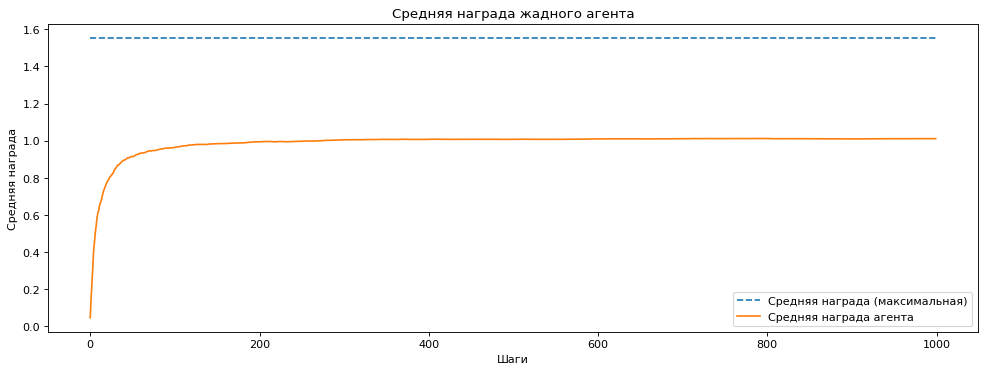

In [11]:
# ---------------
# Дискуссионная ячейка
# ---------------

num_runs = 200                             # количество запусков эксперимента
num_steps = 1000                           # Количество шагов в каждом эксперименте
num_actions = 10                           # Количество действий
env = ten_arm_env.Environment              # Устанавливаем среду
agent_class = GreedyAgent                  # Указываем класс агента
agent_info = {"num_actions": num_actions}  # Информация об агенте
env_info = {}                              # Информация о среде (если есть)

all_averages = []
average_best = 0

for run in tqdm(range(num_runs)):          # tqdm - создает индикатор выполнения
    np.random.seed(run)                    # Устанавливаем фиксированное значение для воспроизводимости

    # Создаем новый эксперимент RLGlue с окружением и классом агента.
    rl_glue = RLGlue(env, lambda: agent_class(num_actions=num_actions))  # Используем лямбду для передачи аргументов при создании агента
    rl_glue.rl_init(agent_info, env_info)                                # Передаем RLGlue все, что нужно для инициализации агента и среды.

    rl_glue.rl_start()                     # Запускаем эксперимент

    # Получаем максимальную награду за все ноги, то есть руки (шутка)
    average_best += np.max(rl_glue.environment.arms)

    scores = [0]
    averages = []

    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step()   # Среда и агент делают шаг и возвращают награду и выбранное действие
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    all_averages.append(averages)

# Строим графикк
plt.figure(figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot([average_best / num_runs for _ in range(num_steps)], linestyle="--", label="Средняя награда (максимальная)")
plt.plot(np.mean(all_averages, axis=0), label="Средняя награда агента")
plt.legend()
plt.title("Средняя награда жадного агента")
plt.xlabel("Шаги")
plt.ylabel("Средняя награда")
plt.show()

greedy_scores = np.mean(all_averages, axis=0)

**Как дела у агента:**

Агент ведет себя неплохо, так как он довольно быстро обучился и достиг стабильного результата. Однако он не всегда выбирает оптимальное действие, так как его средняя награда ниже максимальной. Это типично для жадного алгоритма, который всегда выбирает действия с наивысшей известной наградой, но не исследует новые варианты.

**Можно ли сделать лучше:**

Да, можно сделать лучше. Жадные агенты имеют тенденцию застревать в локальных максимумах, так как они не исследуют все доступные действия. Один из способов улучшить результаты — использовать стратегию с исследованием. Например:

*   eps-жадная стратегия: агент с вероятностью ε выбирает случайное действие (исследует) и с вероятностью 1−eps — жадное (эксплуатирует);
*   UCB: стратегия, которая учитывает как среднюю награду, так и неопределенность в оценках действий;

Эти методы могли бы помочь агенту находить лучшее действие чаще, улучшая среднюю награду.

## Раздел 2: Epsilon-жадный агент

In [12]:
class EpsilonGreedyAgent(main_agent.Agent):
    def __init__(self, num_actions, epsilon):
        super().__init__()  # Вызов конструктора родительского класса
        self.q_values = np.zeros(num_actions)  # Массив для хранения ценностей действий
        self.arm_count = np.zeros(num_actions)  # Счетчики для каждого действия
        self.last_action = None  # Действие, совершенное на предыдущем шаге
        self.epsilon = epsilon  # Вероятность исследования (epsilon)

    def agent_step(self, reward, observation):
        """
        Takes one step for the agent. It takes in a reward and observation and
        returns the action the agent chooses at that time step.

        Arguments:
        reward -- float, the reward the agent received from the environment after taking the last action.
        observation -- float, the observed state the agent is in. Do not worry about this as you will not use it
                              until future lessons
        Returns:
        current_action -- int, the action chosen by the agent at the current time step.
        """

        ### Useful Class Variables ###
        # self.q_values : Массив, содержащий, по мнению агента, ценности каждой руки.
        # self.arm_count : Массив с подсчетом количества выбора каждой руки.
        # self.last_action : Действие, которое агент предпринял на предыдущем шаге времени.
        # self.epsilon : Вероятность того, что эпсилон-жадный агент будет разведывать (колеблется от 0 до 1)
        #######################

        # Обновление ценностей Q
        if self.last_action is not None:
            # Увеличиваем счетчик для действия с предыдущего шага времени
            self.arm_count[self.last_action] += 1

            # Обновление размера шага с использованием self.arm_count
            step_size = 1 / self.arm_count[self.last_action]

            # Обновление self.q_values для действия с предыдущего шага времени
            self.q_values[self.last_action] += step_size * (reward - self.q_values[self.last_action])

        # Выбор действия с использованием эпсилон-жадности
        if np.random.random() < self.epsilon:
            # Случайный выбор действия
            current_action = np.random.randint(len(self.q_values))  # Случайное действие из доступных
        else:
            # Жадный выбор действия
            current_action = argmax(self.q_values)  # Используем функцию argmax для выбора действия с наибольшей ценностью

        self.last_action = current_action

        return current_action

In [17]:
# --------------
# Отладочная ячейка
# --------------

# сделать фейкового агента для тестирования и установки некоторых начальных ограничений
np.random.seed(0)
e_greedy_agent = EpsilonGreedyAgent(num_actions=5, epsilon=0.5)
e_greedy_agent.q_values = [0, 0.0, 0.5, 0, 0]
e_greedy_agent.arm_count = [0, 1, 0, 0, 0]
e_greedy_agent.last_action = 1

# учитывая random.seed, мы должны увидеть здесь жадное действие (действие 2)
action = e_greedy_agent.agent_step(reward=1, observation=0)

# -----------------------------------------------
# попробуем угадать несколько более сложных мест
# -----------------------------------------------

# убедиться, что обновляете *last_action*, а не текущее действие
assert e_greedy_agent.q_values != [0, 0.5, 1.0, 0, 0], "A"

# убедиться, что stepsize основывается на *last_action* а не на текущем действии
assert e_greedy_agent.q_values != [0, 1, 0.5, 0, 0], "B"

# убедитесь, что агент использует argmax, который выбирает максимальные случайным образом
assert action == 2, "C"

# -----------------------------------------------

# посмотрим, что произойдет с другим действием
np.random.seed(1)
e_greedy_agent = EpsilonGreedyAgent(num_actions=5, epsilon=0.5)
e_greedy_agent.q_values = [0, 0.5, 0.5, 0, 0]
e_greedy_agent.arm_count = [0, 1, 0, 0, 0]
e_greedy_agent.last_action = 1

# учитывая этот random.seed, мы должны увидеть здесь случайное действие (действие 4)
action = e_greedy_agent.agent_step(reward=1, observation=0)

# Агент увидел награду 1, поэтому следует увеличить значение для *last_action*
assert e_greedy_agent.q_values == [0, 0.75, 0.5, 0, 0], "D"

# агент должен был выбрать случайное действие для этого конкретного случайного числа
assert action == 4, "E"

In [21]:
# -----------
# Тестовая ячейка
# -----------

np.random.seed(0)
# Создаем экземпляр EpsilonGreedyAgent с необходимыми параметрами
e_greedy_agent = EpsilonGreedyAgent(num_actions=5, epsilon=0.5)
e_greedy_agent.q_values = [0, 0, 1.0, 0, 0]
e_greedy_agent.arm_count = [0, 1, 0, 0, 0]
e_greedy_agent.last_action = 1

# Выполняем шаг агента
action = e_greedy_agent.agent_step(reward=1, observation=0)

# Проверяем обновление Q-значений
assert e_greedy_agent.q_values == [0, 0.5, 1.0, 0, 0]

# Манипулируем random.seed, чтобы агент выполнял случайное действие
np.random.seed(1)
action = e_greedy_agent.agent_step(reward=0, observation=0)

# Проверяем, что действие равно 4
assert action == 4

# Убедиться, что ценность действия 4 обновилась
action = e_greedy_agent.agent_step(reward=1, observation=0)
assert e_greedy_agent.q_values == [0, 0.5, 0.0, 0, 1.0]


100%|██████████| 200/200 [00:06<00:00, 29.03it/s]


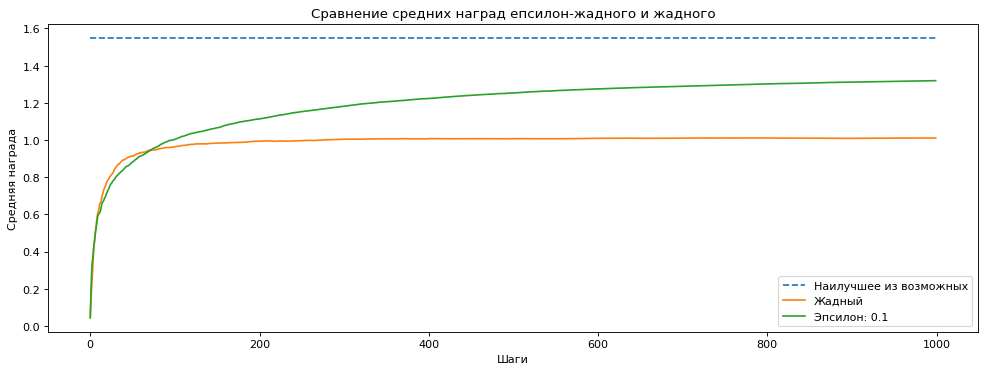

In [23]:
# ---------------
# Дискуссионная ячейка
# ---------------

# Рисует результаты Epsilon-жадных и жадных
num_runs = 200
num_steps = 1000
epsilon = 0.1
num_actions = 10  # Количество действий
agent = EpsilonGreedyAgent
env = ten_arm_env.Environment
agent_info = {"num_actions": num_actions, "epsilon": epsilon}
env_info = {}
all_averages = []

for run in tqdm(range(num_runs)):
    np.random.seed(run)

    # Используем лямбду для передачи аргументов при создании агента
    rl_glue = RLGlue(env, lambda: agent(num_actions=num_actions, epsilon=epsilon))
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()

    scores = [0]
    averages = []
    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step() # Среда и агент делают шаг и возвращают
                                                 # награду и выбранное действие.
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    all_averages.append(averages)

plt.figure(figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--", label="Наилучшее из возможных")
plt.plot(greedy_scores, label="Жадный")
plt.plot(np.mean(all_averages, axis=0), label="Эпсилон: 0.1")
plt.title("Сравнение средних наград епсилон-жадного и жадного")
plt.xlabel("Шаги")
plt.ylabel("Средняя награда")
plt.legend()
plt.show()


## Раздел 2.1 Усреднение многократных запусков

Мы решили провести более 2000 прогонов для стабилизации результатов, достоверности статистики, ну и для изучения поведения агента

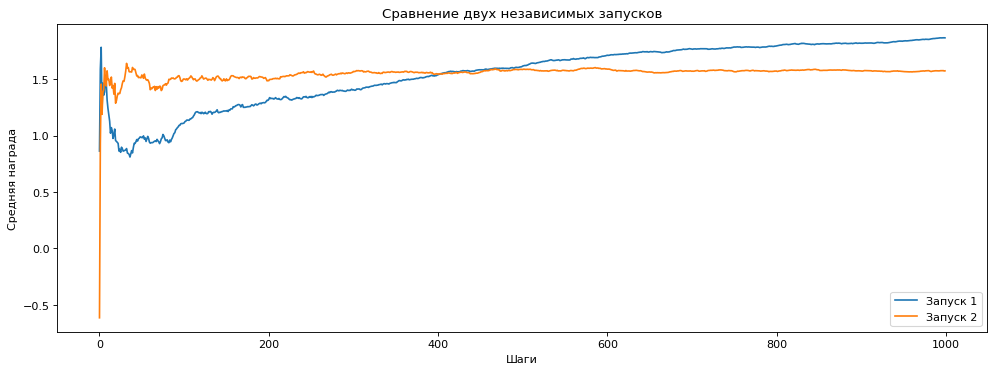

In [26]:
# ---------------
# Дискуссионная ячейка
# ---------------

# график запусков e-greedy агента
agent = EpsilonGreedyAgent
env = ten_arm_env.Environment
epsilon = 0.1
num_actions = 10
agent_info = {"num_actions": num_actions, "epsilon": epsilon}
env_info = {}
all_averages = []
plt.figure(figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
num_steps = 1000

for run in (0, 1):
    np.random.seed(run)  # Здесь мы устанавливаем seed, чтобы сравнить два разных запуска
    averages = []

    # Используем лямбду для передачи аргументов при создании агента
    rl_glue = RLGlue(env, lambda: agent(num_actions=num_actions, epsilon=epsilon))
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()

    scores = [0]
    for i in range(num_steps):
        reward, state, action, is_terminal = rl_glue.rl_step()
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))

    plt.plot(averages)

plt.title("Сравнение двух независимых запусков")
plt.xlabel("Шаги")
plt.ylabel("Средняя награда")
plt.legend(["Запуск 1", "Запуск 2"])
plt.show()


In [27]:
# ---------------
# Дискуссионная ячейка
# ---------------
print("Random Seed 1")
np.random.seed(1)
for _ in range(15):
    if np.random.random() < 0.1:
        print("Разведка")


print()
print()

print("Random Seed 2")
np.random.seed(2)
for _ in range(15):
    if np.random.random() < 0.1:
        print("Разведка")

Random Seed 1
Разведка
Разведка
Разведка


Random Seed 2
Разведка


## Раздел 3: Сравение значений для епсилон


100%|██████████| 200/200 [00:06<00:00, 32.66it/s]


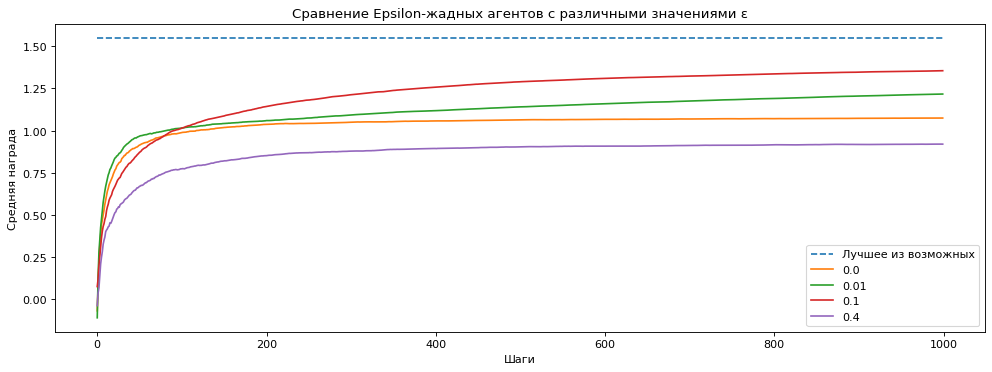

In [29]:
# ---------------
# Дискуссионная ячейка
# ---------------

# Эксперимент для разных e-greedy
epsilons = [0.0, 0.01, 0.1, 0.4]

plt.figure(figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")

n_q_values = []
n_averages = []
n_best_actions = []

num_runs = 200

for epsilon in epsilons:
    all_averages = []
    for run in tqdm(range(num_runs)):
        # Используем лямбду для передачи аргументов при создании агента
        agent = EpsilonGreedyAgent
        agent_info = {"num_actions": 10, "epsilon": epsilon}
        env_info = {"random_seed": run}

        rl_glue = RLGlue(env, lambda: agent(num_actions=10, epsilon=epsilon))  # Передаем параметры через лямбду
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()

        best_arm = np.argmax(rl_glue.environment.arms)

        scores = [0]
        averages = []
        best_action_chosen = []

        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if action == best_arm:
                best_action_chosen.append(1)
            else:
                best_action_chosen.append(0)
            if epsilon == 0.1 and run == 0:
                n_q_values.append(np.copy(rl_glue.agent.q_values))

        if epsilon == 0.1:
            n_averages.append(averages)
            n_best_actions.append(best_action_chosen)

        all_averages.append(averages)

    plt.plot(np.mean(all_averages, axis=0))

plt.legend(["Лучшее из возможных"] + epsilons)
plt.xlabel("Шаги")
plt.ylabel("Средняя награда")
plt.title("Сравнение Epsilon-жадных агентов с различными значениями ε")
plt.show()


Агент 0,01 недостаточно разведывал, из-за чего он выбирал неоптимальную руку чаще. Эпсилон 0,4 разведывает слишком часто и предпринимает много неоптимальных действий, от чего работает хуже в долгосрочной перспективе

## Раздел 4: влияние размера шага

In [31]:
class EpsilonGreedyAgentConstantStepsize(main_agent.Agent):
    def __init__(self, num_actions, epsilon, step_size):
        super().__init__()  # Вызов конструктора родительского класса
        self.q_values = np.zeros(num_actions)  # Массив для хранения ценностей действий
        self.arm_count = np.zeros(num_actions)  # Счетчики для каждого действия (если необходимо)
        self.last_action = None  # Действие, совершенное на предыдущем шаге
        self.step_size = step_size  # Постоянный размер шага
        self.epsilon = epsilon  # Вероятность исследования (epsilon)

    def agent_step(self, reward, observation):
        """
        Делает один шаг за агента. Получает награду и разведку и
         возвращает действие, которое агент выбирает на этом шаге времени.

        Аргументы:
         reward - float, награда, полученная агентом от окружения после выполнения последнего действия.
         observation - float, наблюдаемое состояние, в котором находится агент. Не беспокойтесь об этом, так как вы не будете его использовать
                               до будущих уроков.
        Возврат:
         current_action - int, действие, выбранное агентом на текущем временном шаге.
        """

        ### Useful Class Variables ###
        # self.q_values: массив, содержащий, по мнению агента, ценности каждой руки.
        # self.arm_count: массив со счетчиком количества выбора каждой руки.
        # self.last_action: int, действие, которое агент выполнил на предыдущем временном шаге.
        # self.step_size: float, текущий размер шага агента.
        # self.epsilon: вероятность разведки эпсилон-жадного агента(от 0 до 1)
        #######################

        # Обновить q_values для действий, предпринятых на предыдущем временном шаге
        if self.last_action is not None:
            # Обновляем q_values с использованием постоянного размера шага
            self.q_values[self.last_action] += self.step_size * (reward - self.q_values[self.last_action])

        # Выберите действие с эпсилон-жадным подходом
        if np.random.random() < self.epsilon:
            # Случайный выбор действия (разведка)
            current_action = np.random.randint(len(self.q_values))  # Случайное действие из доступных
        else:
            # Жадный выбор действия (эксплуатация)
            current_action = argmax(self.q_values)  # Используем функцию argmax для выбора действия с наибольшей ценностью

        self.last_action = current_action

        return current_action

In [33]:
# --------------
# Отладочная ячейка
# --------------

for step_size in [0.01, 0.1, 0.5, 1.0]:
    # Создаем экземпляр EpsilonGreedyAgentConstantStepsize с необходимыми параметрами
    e_greedy_agent = EpsilonGreedyAgentConstantStepsize(num_actions=5, epsilon=0.0, step_size=step_size)

    e_greedy_agent.q_values = [0, 0, 1.0, 0, 0]
    e_greedy_agent.last_action = 1

    # Выполняем шаг агента с наградой 1
    action = e_greedy_agent.agent_step(1, 0)

    # Проверяем обновление q_values
    assert e_greedy_agent.q_values == [0, step_size, 1.0, 0, 0], "Убедитесь, что вы правильно обновляете q_values, используя размер шага."

In [37]:
# -----------
# Тестовая ячейка
# -----------

np.random.seed(0)
# Проверить Epsilon Greedy с разными постоянными размерами шага
for step_size in [0.01, 0.1, 0.5, 1.0]:
    # Создаем экземпляр EpsilonGreedyAgentConstantStepsize с необходимыми параметрами
    e_greedy_agent = EpsilonGreedyAgentConstantStepsize(num_actions=5, epsilon=0.0, step_size=step_size)

    e_greedy_agent.q_values = [0, 0, 1.0, 0, 0]
    e_greedy_agent.last_action = 1

    # Выполняем шаг агента с наградой 1
    action = e_greedy_agent.agent_step(1, 0)

    # Проверяем обновление q_values
    assert e_greedy_agent.q_values == [0, step_size, 1.0, 0, 0]


100%|██████████| 200/200 [00:07<00:00, 28.21it/s]
<ipython-input-40-fdba21e16d7b>:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])


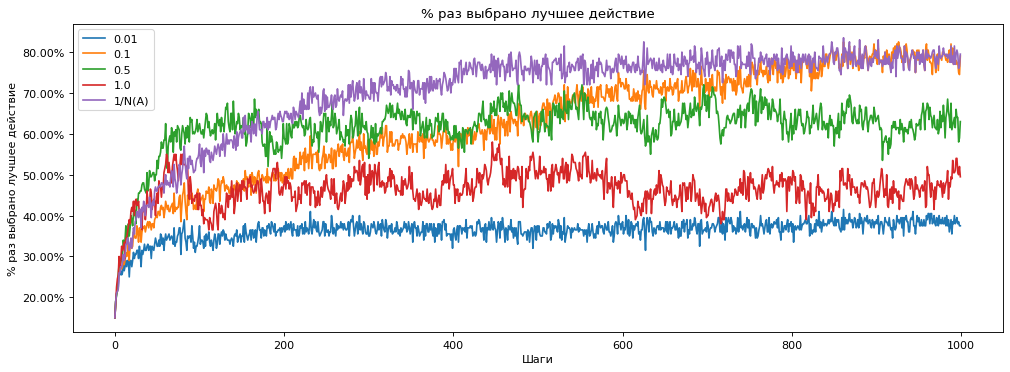

In [40]:
# ---------------
# Дискуссионная ячейка
# ---------------

# Эксперимент для разных размеров шага
step_sizes = [0.01, 0.1, 0.5, 1.0, '1/N(A)']

epsilon = 0.1
num_steps = 1000
num_runs = 200

fig, ax = plt.subplots(figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')

q_values = {step_size: [] for step_size in step_sizes}
true_values = {step_size: None for step_size in step_sizes}
best_actions = {step_size: [] for step_size in step_sizes}

for step_size in step_sizes:
    all_averages = []
    for run in tqdm(range(num_runs)):
        np.random.seed(run)

        # Условие для выбора агента и его параметров
        if step_size == '1/N(A)':
            agent = EpsilonGreedyAgent
            agent_info = {"num_actions": 10, "epsilon": epsilon}
        else:
            agent = EpsilonGreedyAgentConstantStepsize
            agent_info = {"num_actions": 10, "epsilon": epsilon, "step_size": step_size}

        env_info = {}

        # Передаем лямбду для создания агента с параметрами
        rl_glue = RLGlue(env, lambda: agent(num_actions=10, epsilon=epsilon, step_size=step_size) if agent == EpsilonGreedyAgentConstantStepsize else agent(num_actions=10, epsilon=epsilon))
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()

        best_arm = np.argmax(rl_glue.environment.arms)

        scores = [0]
        averages = []

        if run == 0:
            true_values[step_size] = np.copy(rl_glue.environment.arms)

        best_action_chosen = []
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if action == best_arm:
                best_action_chosen.append(1)
            else:
                best_action_chosen.append(0)
            if run == 0:
                q_values[step_size].append(np.copy(rl_glue.agent.q_values))

        best_actions[step_size].append(best_action_chosen)

    ax.plot(np.mean(best_actions[step_size], axis=0))

plt.legend(step_sizes)
plt.title("% раз выбрано лучшее действие")
plt.xlabel("Шаги")
plt.ylabel("% раз выбрано лучшее действие")
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.show()


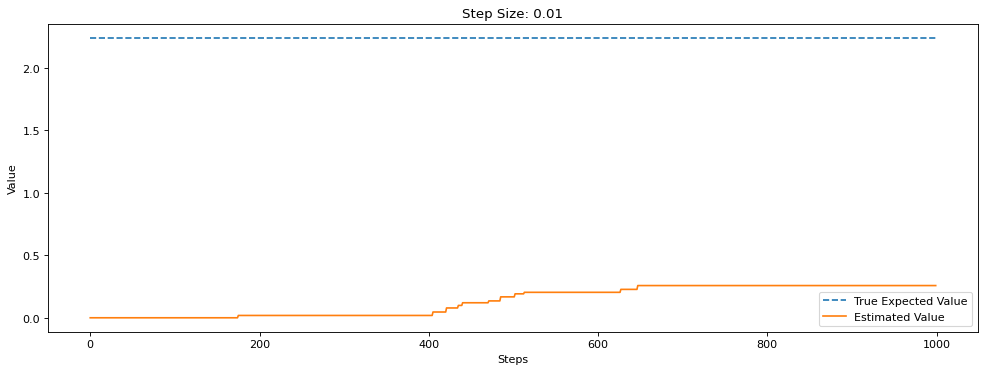

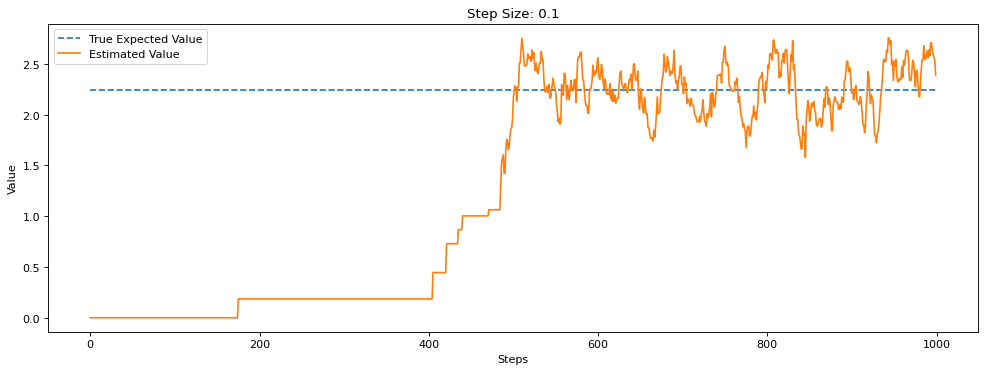

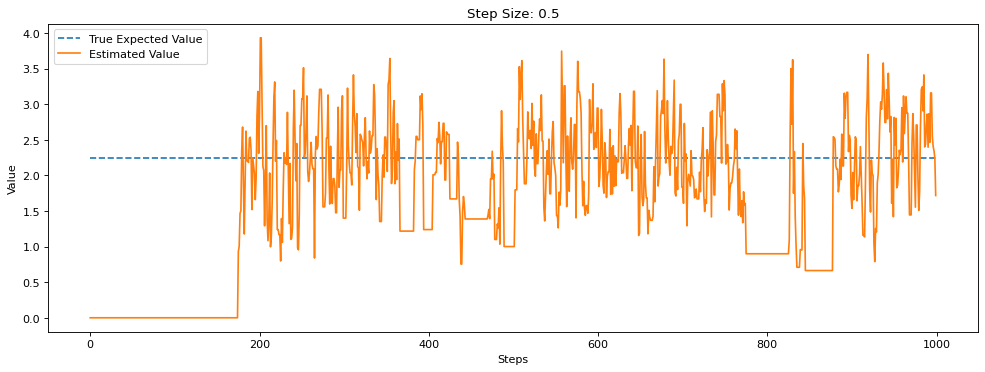

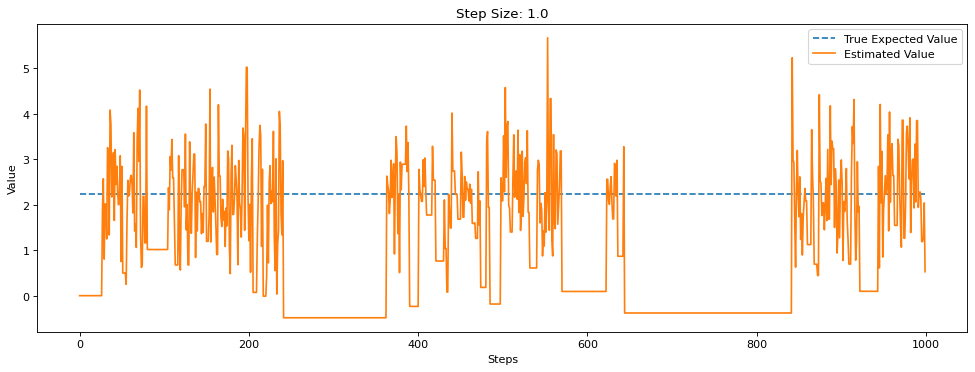

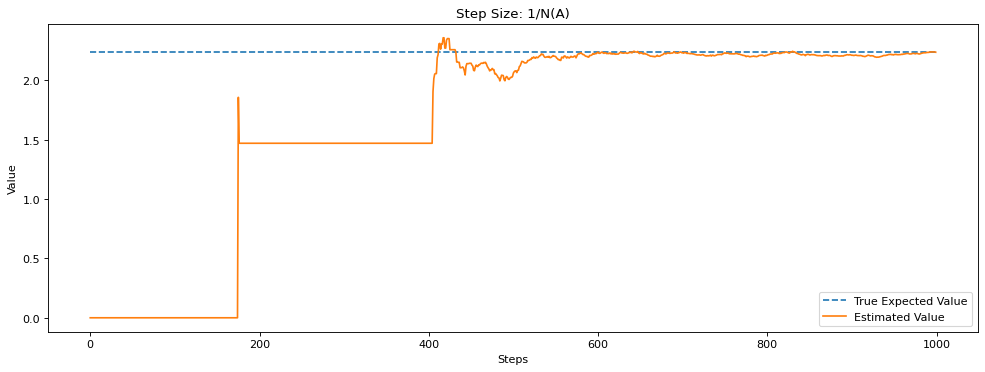

In [41]:
# lock
# ---------------
# Discussion Cell
# ---------------
largest = 0
num_steps = 1000
for step_size in step_sizes:
    plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
    largest = np.argmax(true_values[step_size])
    plt.plot([true_values[step_size][largest] for _ in range(num_steps)], linestyle="--")
    plt.title("Step Size: {}".format(step_size))
    plt.plot(np.array(q_values[step_size])[:, largest])
    plt.legend(["True Expected Value", "Estimated Value"])
    plt.xlabel("Steps")
    plt.ylabel("Value")
    plt.show()

100%|██████████| 200/200 [00:13<00:00, 14.33it/s]


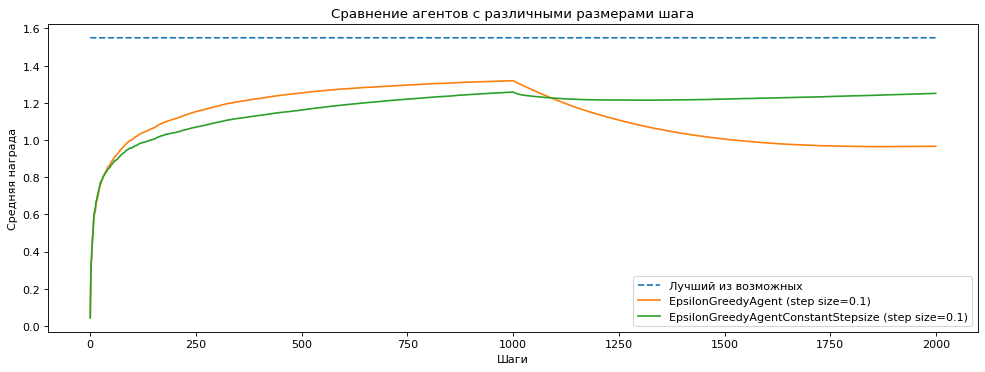

In [44]:
# ---------------
# Дискуссионная ячейка
# ---------------

epsilon = 0.1
num_steps = 2000
num_runs = 200
step_size = 0.1

plt.figure(figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--", label="Лучший из возможных")

for agent in [EpsilonGreedyAgent, EpsilonGreedyAgentConstantStepsize]:
    all_averages = []
    for run in tqdm(range(num_runs)):
        # Условие для выбора параметров агента
        if agent == EpsilonGreedyAgent:
            agent_info = {"num_actions": 10, "epsilon": epsilon}
        else:
            agent_info = {"num_actions": 10, "epsilon": epsilon, "step_size": step_size}

        np.random.seed(run)

        # Используем лямбда-функцию для создания агента с параметрами
        rl_glue = RLGlue(env, lambda: agent(num_actions=10, epsilon=epsilon, step_size=step_size) if agent == EpsilonGreedyAgentConstantStepsize else agent(num_actions=10, epsilon=epsilon))
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()

        scores = [0]
        averages = []

        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if i == 1000:
                rl_glue.environment.arms = np.random.randn(10)  # Изменяем среду на шаге 1000

        all_averages.append(averages)

    plt.plot(np.mean(all_averages, axis=0), label=f"{agent.__name__} (step size={step_size})")

plt.legend()
plt.xlabel("Шаги")
plt.ylabel("Средняя награда")
plt.title("Сравнение агентов с различными размерами шага")
plt.show()
